Non-square-root version of parsmooth

### Imports

In [1]:
from jax.config import config

config.update("jax_enable_x64", True)

import parsmooth
from parsmooth.sequential import ieks as seq_ieks
from parsmooth.parallel import ekf
from parsmooth.utils import MVNormalParameters

In [2]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import tornadox

## Initial Value Problem

In [3]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e0)
ylims = (-3, 3)
f = ivp.f
y0 = ivp.y0
t0, tmax = ivp.t0, ivp.tmax

## Definig the ODE Solver

In [4]:
# Fixed-step solver with step-size
dt = 1e-3

# Solver order
order = 3

### 1. Prior
Build the transition matrices (using `tornadox` because I'm lazy)

In [5]:
d, q = len(y0), order
D = d * (q+1)
diffusion = 1

iwp = tornadox.iwp.IntegratedWienerTransition(
    num_derivatives=q, wiener_process_dimension=d)
E0 = iwp.projection_matrix(0)
E1 = iwp.projection_matrix(1)
A, QS = iwp.non_preconditioned_discretize(dt)
Q = diffusion * (QS @ QS.T)

@jax.jit
def tf(x, A):
    return A @ x

transition_function = jax.jit(partial(tf, A=A))

### 2. Observation Model

In [6]:
def of(x, f, E0, E1):
    return E1@x - f(None, E0@x)

observation_function = jax.jit(partial(of, f=f, E0=E0, E1=E1))

R = 0 * jnp.eye(d)

### 3. Data
We want the ODE to be satisfied == we want the difference to be zero == zero data:

In [7]:
ts = jnp.arange(t0, tmax+dt, dt)
data = jnp.zeros((len(ts)-1, d))
print(data.shape)

(6300, 2)


## 4. Initial state
Again computed with `tornadox`:

In [8]:
m0, P0 = tornadox.init.TaylorMode()(
    f=f, df=None, y0=y0, t0=0, num_derivatives=order)
m0, P0 = jnp.concatenate(m0.T), jnp.kron(jnp.eye(d), P0)
x0 = MVNormalParameters(m0, P0)

In [9]:
observation_function(m0)

DeviceArray([0., 0.], dtype=float64)


## Solve the ODE with `parsmooth`

(-3.0, 3.0)

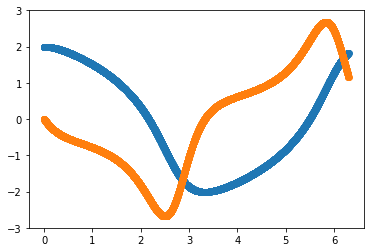

In [10]:
_, ekf_res = parsmooth.sequential.ekf(
    x0, data, transition_function, Q, observation_function, R, None
)
plt.plot(ts, jnp.dot(E0, ekf_res.mean.T).T, marker="o")
plt.ylim(ylims)